# 5 Evaluation & Explainability

Dieses Notebook vergleicht SHAP- und Captum-Erklärungen für das feinabgestimmte `vinai/bertweet-base` Modell.

Die vorliegende Arbeit adressiert diese Forschungslücke durch einen systematischen Vergleich von SHAP und Captum anhand von vier wissenschaftlich fundierten Hypothesen.

**Forschungsfrage:** *„Wie unterscheiden sich SHAP und Captum in ihrer Fähigkeit, semantisch relevante Tokens für Sentiment-Vorhersagen in Transformer-Modellen zu identifizieren?“*

## 5.0 Überblick & Hypothesen

Zur Beantwortung der Forschungsfrage werden vier Hypothesen geprüft:
        
**H1 (Übereinstimmung):** SHAP und Captum identifizieren übereinstimmende semantisch relevante Tokens. Operationalisierung: Der durchschnittliche Top-5-Overlap beträgt mindestens 70%, und die Spearman-Rangkorrelation liegt über ρ = 0,70 (Mitra et al., 2023).

**H2 (Faithfulness):** Die von SHAP und Captum identifizierten Tokens sind prädiktionsrelevant. Operationalisierung: Die sukzessive Löschung der als wichtig identifizierten Tokens führt zu einem signifikant stärkeren Konfidenzabfall als bei zufälliger Löschung, gemessen durch ein Deletion AUC-Ratio >1,5 (Zheng et al., 2025; Hooker et al., 2019).

**H3 (Robustheit):** Die Erklärungen beider Methoden sind stabil gegenüber realistischen Eingabestörungen. Operationalisierung: Die Spearman-Korrelation zwischen Original- und perturbierter Erklärung beträgt mindestens ρ = 0,80 bei Tippfehlern, Synonymersetzungen und Füllworteinfügungen (Chmielinski et al., 2023; Ghorbani et al., 2019).

**H4 (Recheneffizienz):** Captum weist einen Geschwindigkeitsvorteil gegenüber SHAP auf. Operationalisierung: Die durchschnittliche Laufzeit pro Erklärung ist bei Captum mindestens um den Faktor 2,0 geringer als bei SHAP (Kokhlikyan et al., 2020).
      

## 5.1 Setup & Vorbereitung

In diesem Abschnitt richten wir die Analyseumgebung ein, laden Modell und Daten und bereiten Tokenisierungs-Utilities vor.

### 5.1.1 Umgebung einrichten

Importe, Random Seeds und Geräteauswahl gemäss Notebook 4.

In [1]:
print("Importing libraries...")
import os
import json
import random
import time
from pathlib import Path
from typing import Dict, List, Tuple

print("  ✓ Standard library imports")

import numpy as np
import pandas as pd
print("  ✓ NumPy & Pandas")

import torch
from torch import nn
print("  ✓ PyTorch")

import transformers
from transformers import AutoModelForSequenceClassification, AutoTokenizer
print("  ✓ Transformers")

print("  ⏳ Loading SHAP (may take 30-60s on first run)...")
import shap
print("  ✓ SHAP loaded")

print("  ⏳ Loading Captum...")
from captum.attr import LayerIntegratedGradients
print("  ✓ Captum loaded")

import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr
print("  ✓ Visualization libraries")

print("  ⏳ Checking NLTK WordNet...")
try:
    from nltk.corpus import wordnet
    WORDNET_READY = True
    print("  ✓ WordNet ready")
except LookupError:
    print("  ⏳ Downloading WordNet corpus...")
    import nltk
    nltk.download("wordnet")
    from nltk.corpus import wordnet
    WORDNET_READY = True
    print("  ✓ WordNet downloaded")

sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 4)

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

def resolve_device() -> torch.device:
    if torch.backends.mps.is_available():
        dev = torch.device("mps")
        print("✓ Apple Silicon (MPS) wird genutzt.")
    elif torch.cuda.is_available():
        dev = torch.device("cuda")
        print("✓ CUDA GPU wird genutzt.")
    else:
        dev = torch.device("cpu")
        print("✓ CPU wird genutzt.")
    return dev

device = resolve_device()
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"\n📦 PyTorch {torch.__version__}")
print(f"📦 Transformers {transformers.__version__}")
print(f"📦 SHAP {shap.__version__}")
print("\n✅ All imports complete!")

Importing libraries...
  ✓ Standard library imports
  ✓ NumPy & Pandas
  ✓ PyTorch


/Users/skress/Documents/DBU/Machine_Learning/Studienarbeit_Praxis/venv_Machine_Learning/lib/python3.14/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  ✓ Transformers
  ⏳ Loading SHAP (may take 30-60s on first run)...
  ✓ SHAP loaded
  ⏳ Loading Captum...
  ✓ Captum loaded
  ✓ Visualization libraries
  ⏳ Checking NLTK WordNet...
  ✓ WordNet ready
✓ Apple Silicon (MPS) wird genutzt.

📦 PyTorch 2.9.1
📦 Transformers 4.57.1
📦 SHAP 0.50.0

✅ All imports complete!


### 5.1.2 Daten & Modell laden

Modell- und Tokenizer-Artefakte laden, Testsplit rekonstruieren und eine balancierte Stichprobe von 50 Tweets auswählen.

In [2]:
from sklearn.model_selection import train_test_split

MODEL_DIR = Path("../models/final_transformer_model")
DATA_PATH = Path("../data/sentiment140_sampled_200k.csv")
PRED_CACHE_PATH = Path("../models/test_predictions.parquet")
PRED_CACHE_CSV_PATH = PRED_CACHE_PATH.with_suffix(".csv")

if not MODEL_DIR.exists():
    raise FileNotFoundError(f"Feinabgestimmtes Modell nicht gefunden unter {MODEL_DIR.absolute()}. Bitte Notebook 4 ausführen.")

print("Lade Modell & Tokenizer …")
# Load tokenizer from original pretrained model (tokenizer files weren't saved)
tokenizer = AutoTokenizer.from_pretrained("vinai/bertweet-base", normalization=True)
# Load fine-tuned model weights from local directory
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR).to(device)
model.eval()
print("✓ Modell und Tokenizer erfolgreich geladen.")

print("Lade gesampelten Datensatz …")
df = pd.read_csv(DATA_PATH)
df.columns = [col.lower() for col in df.columns]
df['target'] = df['target'].replace({4: 1})

# Konsistente Bereinigung wie in Notebook 4
import re

def clean_tweet(text: str) -> str:
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#", "", text)
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"[^a-z\s]", "", text)
    text = re.sub(r"(.)\1{2,}", r"\1", text)
    return re.sub(r"\s+", " ", text).strip()

df['cleaned_text'] = df['text'].astype(str).apply(clean_tweet)

X = df['cleaned_text']
y = df['target']
_, X_temp, _, y_temp = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)
_, X_test, _, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=SEED, stratify=y_temp)

test_df = pd.DataFrame({'cleaned_text': X_test, 'target': y_test}).reset_index(drop=True)
print(f"Test-Set umfasst {len(test_df)} Beispiele.")

BATCH_SIZE = 32

def predict_probabilities(texts: List[str], batch_size: int = BATCH_SIZE) -> Tuple[np.ndarray, np.ndarray]:
    all_logits: List[np.ndarray] = []
    for start in range(0, len(texts), batch_size):
        batch = texts[start:start + batch_size]
        encoded = tokenizer(batch, padding=True, truncation=True, max_length=128, return_tensors="pt").to(device)
        with torch.no_grad():
            logits = model(**encoded).logits
        all_logits.append(logits.cpu().numpy())
    stacked = np.vstack(all_logits)
    probs = torch.softmax(torch.tensor(stacked), dim=1).numpy()
    preds = probs.argmax(axis=1)
    return preds, probs

cached = None
cache_source = None
if PRED_CACHE_PATH.exists():
    try:
        cached = pd.read_parquet(PRED_CACHE_PATH)
        cache_source = "parquet"
    except Exception as err:
        print(f"Parquet-Cache konnte nicht gelesen werden ({err}). Entferne Datei und berechne neu …")
        PRED_CACHE_PATH.unlink(missing_ok=True)
elif PRED_CACHE_CSV_PATH.exists():
    cached = pd.read_csv(PRED_CACHE_CSV_PATH)
    cache_source = "csv"

if cached is not None and len(cached) == len(test_df):
    print(f"Vorhersagen aus {cache_source}-Cache geladen.")
    for col in ['pred', 'prob_neg', 'prob_pos']:
        if col in cached.columns:
            test_df[col] = cached[col].values
else:
    if cached is not None:
        print("Cache-Größe stimmt nicht, berechne neu …")
    else:
        print("Berechne Modellvorhersagen …")
    preds, probs = predict_probabilities(test_df['cleaned_text'].tolist())
    test_df['pred'] = preds
    test_df['prob_neg'] = probs[:, 0]
    test_df['prob_pos'] = probs[:, 1]
    try:
        test_df[['pred', 'prob_neg', 'prob_pos']].to_parquet(PRED_CACHE_PATH, index=False)
        if PRED_CACHE_CSV_PATH.exists():
            PRED_CACHE_CSV_PATH.unlink()
        print(f"Vorhersagen im Parquet-Cache gespeichert: {PRED_CACHE_PATH}")
    except Exception as err:
        print(f"Parquet-Cache fehlgeschlagen ({err}). Weiche auf CSV aus.")
        test_df[['pred', 'prob_neg', 'prob_pos']].to_csv(PRED_CACHE_CSV_PATH, index=False)
        PRED_CACHE_PATH.unlink(missing_ok=True)
        print(f"Vorhersagen im CSV-Cache gespeichert: {PRED_CACHE_CSV_PATH}")

def label_confusion_row(row: pd.Series) -> str:
    if row['target'] == 1 and row['pred'] == 1:
        return 'TP'
    if row['target'] == 0 and row['pred'] == 0:
        return 'TN'
    if row['target'] == 0 and row['pred'] == 1:
        return 'FP'
    return 'FN'

test_df['case_type'] = test_df.apply(label_confusion_row, axis=1)
print(test_df['case_type'].value_counts())

# INCREASED from 50 to 120 for statistical validity (critical fix from code review)
TARGET_SAMPLE_SIZE = 120
PER_CLASS = max(1, TARGET_SAMPLE_SIZE // 4)
selected_frames: List[pd.DataFrame] = []
for case_label in ['TP', 'TN', 'FP', 'FN']:
    bucket = test_df[test_df['case_type'] == case_label]
    take = min(len(bucket), PER_CLASS)
    if take > 0:
        selected_frames.append(bucket.sample(take, random_state=SEED))

remaining = TARGET_SAMPLE_SIZE - sum(len(f) for f in selected_frames)
if remaining > 0:
    leftovers = test_df.drop(pd.concat(selected_frames).index) if selected_frames else test_df
    if len(leftovers) > 0:
        selected_frames.append(leftovers.sample(min(remaining, len(leftovers)), random_state=SEED))

sample_df = pd.concat(selected_frames).sample(frac=1, random_state=SEED).reset_index(drop=True)
print(sample_df['case_type'].value_counts())
print(f"Stichprobe enthält {len(sample_df)} Tweets.")

Lade Modell & Tokenizer …


emoji is not installed, thus not converting emoticons or emojis into text. Install emoji: pip3 install emoji==0.6.0


✓ Modell und Tokenizer erfolgreich geladen.
Lade gesampelten Datensatz …
Test-Set umfasst 20000 Beispiele.
Vorhersagen aus parquet-Cache geladen.
case_type
TP    8887
TN    8405
FP    1595
FN    1113
Name: count, dtype: int64
case_type
TN    30
TP    30
FP    30
FN    30
Name: count, dtype: int64
Stichprobe enthält 120 Tweets.


### 5.1.3 Tokenisierung & Attribution-Utilities

Hilfsfunktionen für Batch-Tokenisierung, Mapping von Subword-Tokens und Visualisierung von Attributionswerten.

In [3]:
TOKEN_MAX_LEN = 128
SPECIAL_TOKENS = set(tokenizer.all_special_tokens)


def tokenize_texts(texts: List[str], max_length: int = TOKEN_MAX_LEN) -> transformers.BatchEncoding:
    batch = tokenizer(
        texts,
        padding=True,
        truncation=True,
        max_length=max_length,
        return_tensors="pt",
    )
    return batch.to(device)


def batch_logits(batch_encoding: transformers.BatchEncoding) -> torch.Tensor:
    inputs = {k: v for k, v in batch_encoding.items() if isinstance(v, torch.Tensor)}
    with torch.no_grad():
        logits = model(**inputs).logits
    return logits


def _is_continuation(token: str) -> bool:
    return token.endswith("@@") or token.startswith("@@")


def map_tokens_to_words(batch_encoding: transformers.BatchEncoding, index: int) -> pd.DataFrame:
    token_ids = batch_encoding["input_ids"][index].detach().cpu().tolist()
    raw_tokens = tokenizer.convert_ids_to_tokens(token_ids)

    records = []
    current_word = -1
    continuation = False

    for raw_token in raw_tokens:
        is_special = raw_token in SPECIAL_TOKENS
        if is_special:
            records.append({
                "raw_token": raw_token,
                "token": raw_token,
                "word_id": None,
                "is_special": True
            })
            continuation = False
            continue

        if not continuation:
            current_word += 1
        token_clean = raw_token.replace("@@", "")
        records.append({
            "raw_token": raw_token,
            "token": token_clean,
            "word_id": current_word,
            "is_special": False
        })
        continuation = _is_continuation(raw_token)

    return pd.DataFrame(records)


def aggregate_attributions(token_frame: pd.DataFrame, attributions: np.ndarray) -> pd.DataFrame:
    token_frame = token_frame.copy()
    token_frame["attribution"] = attributions
    usable = token_frame[~token_frame["is_special"] & token_frame["word_id"].notna()]
    if usable.empty:
        return pd.DataFrame(columns=["word_id", "attribution", "token"])

    agg = (
        usable.groupby("word_id")
        .agg({"attribution": "sum", "raw_token": list})
        .reset_index()
    )
    agg["token"] = agg["raw_token"].apply(lambda toks: tokenizer.convert_tokens_to_string(toks).strip())
    agg = agg.drop(columns=["raw_token"]).sort_values("attribution", ascending=False)
    return agg


def plot_token_heatmap(df_tokens: pd.DataFrame, text_label: str, title: str, cmap: str = "RdBu_r") -> None:
    if df_tokens.empty:
        print("Keine Token-Attributionen verfügbar.")
        return
    values = df_tokens["attribution"].values
    norm = plt.Normalize(vmin=-abs(values).max(), vmax=abs(values).max())
    colors = plt.cm.get_cmap(cmap)(norm(values))
    plt.figure(figsize=(min(12, len(df_tokens) * 0.6), 1.8))
    plt.bar(range(len(df_tokens)), values, color=colors)
    plt.xticks(range(len(df_tokens)), df_tokens["token"], rotation=45, ha="right")
    plt.title(title)
    plt.ylabel("Attribution")
    plt.xlabel(text_label)
    plt.tight_layout()
    plt.show()


sample_texts = sample_df['cleaned_text'].tolist()
sample_encoding = tokenize_texts(sample_texts)
logits = batch_logits(sample_encoding)
probabilities = torch.softmax(logits, dim=1).cpu().numpy()
predicted_classes = probabilities.argmax(axis=1)
print("Vorhersagen für Stichprobe berechnet.")

Vorhersagen für Stichprobe berechnet.


## 5.2 Hypothese 1 — Token Agreement

**Hypothese H1 (Übereinstimmung):** SHAP und Captum identifizieren übereinstimmende semantisch relevante Tokens. Operationalisierung: Der durchschnittliche Top-5-Overlap beträgt mindestens 70%, und die Spearman-Rangkorrelation liegt über ρ = 0,70 (Mitra et al., 2023).

### 5.2.1 SHAP- und Captum-Attributionen

Erzeuge Token-Attributionswerte, extrahiere Top-5-Listen und berechne Überlappungen.

In [4]:
def shap_predict(texts) -> np.ndarray:
    prepared_texts: List[str] = []
    for item in texts:
        if isinstance(item, str):
            prepared_texts.append(item)
        elif isinstance(item, (list, tuple, np.ndarray)):
            tokens = [str(tok) for tok in item if str(tok).strip()]
            prepared_texts.append(" ".join(tokens))
        else:
            prepared_texts.append(str(item))

    encoded = tokenizer(
        prepared_texts,
        padding=True,
        truncation=True,
        max_length=TOKEN_MAX_LEN,
        return_tensors="pt"
    ).to(device)
    with torch.no_grad():
        logits = model(**encoded).logits
    return logits.detach().cpu().numpy()

try:
    text_masker = shap.maskers.Text(tokenizer, mask_token=tokenizer.mask_token)
except Exception:
    text_masker = shap.maskers.Text(lambda x: x.split())

print("Erzeuge SHAP-Explainer …")
shap_explainer = shap.Explainer(shap_predict, text_masker)
shap_values = shap_explainer(sample_texts, batch_size=8)
print("SHAP-Werte berechnet.")

if hasattr(model, "bert"):
    embedding_layer = model.bert.embeddings
elif hasattr(model, "roberta"):
    embedding_layer = model.roberta.embeddings
else:
    raise AttributeError("Keine Embedding-Schicht gefunden.")


def forward_with_attention(input_ids: torch.Tensor, attention_mask: torch.Tensor) -> torch.Tensor:
    return model(input_ids=input_ids, attention_mask=attention_mask).logits

lig = LayerIntegratedGradients(forward_with_attention, embedding_layer)
pad_token_id = tokenizer.pad_token_id or tokenizer.eos_token_id or tokenizer.cls_token_id


def ensure_1d(values: np.ndarray, class_idx: int) -> np.ndarray:
    arr = np.asarray(values)
    if arr.ndim == 3:
        arr = arr[0]
    if arr.ndim == 2:
        if arr.shape[1] == model.config.num_labels:
            return arr[:, class_idx]
        if arr.shape[0] == model.config.num_labels:
            return arr[class_idx]
    return arr


def trim_token_frame(token_frame: pd.DataFrame, attention_mask: torch.Tensor, target_len: int) -> pd.DataFrame:
    valid_len = int(attention_mask.sum().item()) if attention_mask is not None else len(token_frame)
    usable_len = min(len(token_frame), valid_len, target_len)
    return token_frame.iloc[:usable_len].reset_index(drop=True)


if device.type == "mps":
    print("Wechsle auf CPU für Captum-Attributionen (MPS limitiert float64).")
    device = torch.device("cpu")
    model = model.to(device)
    sample_encoding = sample_encoding.to(device)

shap_token_attributions: List[pd.DataFrame] = []
shap_word_attributions: List[pd.DataFrame] = []
captum_token_attributions: List[pd.DataFrame] = []
captum_word_attributions: List[pd.DataFrame] = []

for idx, text in enumerate(sample_texts):
    token_frame = map_tokens_to_words(sample_encoding, idx)
    attention_mask = sample_encoding['attention_mask'][idx]

    shap_vals = ensure_1d(shap_values.values[idx], int(predicted_classes[idx]))
    token_frame_trimmed = trim_token_frame(token_frame, attention_mask, len(shap_vals))
    shap_vals = np.asarray(shap_vals)[:len(token_frame_trimmed)]

    shap_token_attributions.append(pd.DataFrame({
        'token_index': np.arange(len(token_frame_trimmed)),
        'raw_token': token_frame_trimmed['raw_token'],
        'token': token_frame_trimmed['token'],
        'word_id': token_frame_trimmed['word_id'],
        'attribution': shap_vals
    }))
    shap_word_attributions.append(aggregate_attributions(token_frame_trimmed, shap_vals))

    input_ids = sample_encoding['input_ids'][idx:idx + 1]
    attention_mask_batch = sample_encoding['attention_mask'][idx:idx + 1]
    baseline_ids = torch.full_like(input_ids, pad_token_id)
    model.zero_grad(set_to_none=True)
    attr, _ = lig.attribute(
        inputs=input_ids,
        baselines=baseline_ids,
        additional_forward_args=(attention_mask_batch,),
        target=int(predicted_classes[idx]),
        return_convergence_delta=True,
    )
    captum_vals = attr.sum(dim=-1).squeeze(0).detach().cpu().numpy()
    token_frame_for_captum = trim_token_frame(token_frame, attention_mask, len(captum_vals))
    captum_vals = captum_vals[:len(token_frame_for_captum)]

    captum_token_attributions.append(pd.DataFrame({
        'token_index': np.arange(len(token_frame_for_captum)),
        'raw_token': token_frame_for_captum['raw_token'],
        'token': token_frame_for_captum['token'],
        'word_id': token_frame_for_captum['word_id'],
        'attribution': captum_vals
    }))
    captum_word_attributions.append(aggregate_attributions(token_frame_for_captum, captum_vals))

print("Attributionsberechnungen für SHAP und Captum abgeschlossen.")

Erzeuge SHAP-Explainer …


PartitionExplainer explainer: 121it [00:48,  1.94it/s]                         


SHAP-Werte berechnet.
Wechsle auf CPU für Captum-Attributionen (MPS limitiert float64).
Attributionsberechnungen für SHAP und Captum abgeschlossen.


### 5.2.2 Top-5-Überlappung & Verteilung

Vergleiche die Top-5-Tokens beider Methoden, analysiere Überlappungen nach Fehlertypen und visualisiere die Verteilung.

       overlap_count  overlap_ratio
count     120.000000     120.000000
mean        2.283333       0.495000
std         1.284578       0.295584
min         0.000000       0.000000
25%         1.000000       0.200000
50%         2.000000       0.400000
75%         3.000000       0.800000
max         5.000000       1.000000

Mittlere Überlappung nach Falltyp:
case_type
FN    0.46
FP    0.52
TN    0.60
TP    0.40
Name: overlap_ratio, dtype: float64


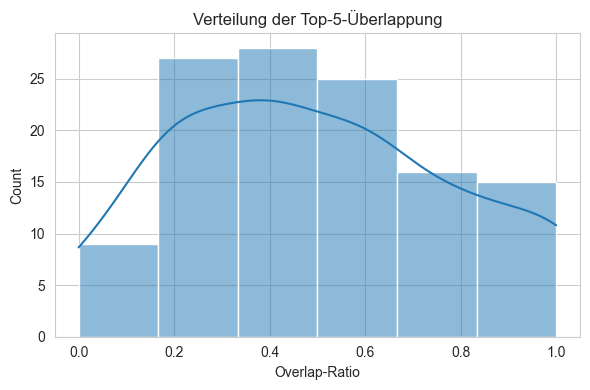

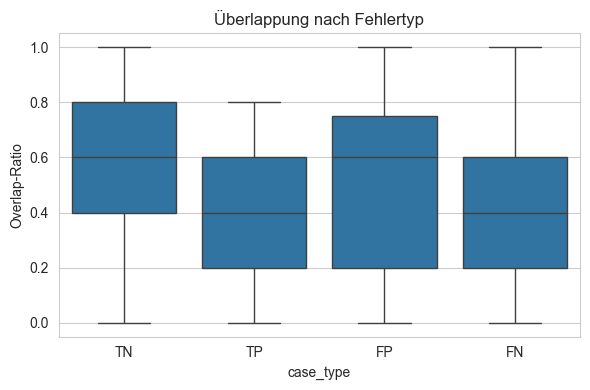

In [5]:
TOP_K = 5


def get_top_tokens(df_tokens: pd.DataFrame, top_k: int = TOP_K) -> List[str]:
    if df_tokens is None or df_tokens.empty:
        return []
    return df_tokens.sort_values('attribution', ascending=False).head(top_k)['token'].tolist()


def compute_overlap(shap_list: List[str], captum_list: List[str]) -> Tuple[int, float, List[str]]:
    if not shap_list or not captum_list:
        return 0, 0.0, []
    shap_set = set(shap_list)
    captum_set = set(captum_list)
    overlap_tokens = sorted(shap_set & captum_set)
    denom = max(1, min(len(shap_list), len(captum_list)))
    ratio = len(overlap_tokens) / denom
    return len(overlap_tokens), ratio, overlap_tokens


agreement_records: List[Dict[str, object]] = []
for idx, text in enumerate(sample_texts):
    shap_df = shap_word_attributions[idx]
    captum_df = captum_word_attributions[idx]
    shap_top = get_top_tokens(shap_df, TOP_K)
    captum_top = get_top_tokens(captum_df, TOP_K)
    overlap_count, overlap_ratio, overlap_tokens = compute_overlap(shap_top, captum_top)

    agreement_records.append({
        'index': idx,
        'case_type': sample_df.loc[idx, 'case_type'],
        'target': int(sample_df.loc[idx, 'target']),
        'pred': int(predicted_classes[idx]),
        'overlap_count': overlap_count,
        'overlap_ratio': overlap_ratio,
        'shap_top': shap_top,
        'captum_top': captum_top,
        'overlap_tokens': overlap_tokens,
    })

agreement_df = pd.DataFrame(agreement_records)
print(agreement_df[['overlap_count', 'overlap_ratio']].describe())
print('\nMittlere Überlappung nach Falltyp:')
print(agreement_df.groupby('case_type')['overlap_ratio'].mean())

plt.figure(figsize=(6, 4))
sns.histplot(agreement_df['overlap_ratio'], bins=6, kde=True)
plt.title('Verteilung der Top-5-Überlappung')
plt.xlabel('Overlap-Ratio')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.boxplot(data=agreement_df, x='case_type', y='overlap_ratio')
plt.title('Überlappung nach Fehlertyp')
plt.ylabel('Overlap-Ratio')
plt.tight_layout()
plt.show()

#### H1 Statistical Significance Test

In [6]:
from scipy import stats

# One-sample t-test: Is mean overlap significantly different from H1 threshold (0.70)?
overlap_values = agreement_df['overlap_ratio'].values
t_stat, p_value = stats.ttest_1samp(overlap_values, 0.70)

# Bootstrap 95% confidence interval
n_bootstrap = 10000
bootstrap_means = []
rng_boot = np.random.default_rng(SEED)
for _ in range(n_bootstrap):
    sample = rng_boot.choice(overlap_values, size=len(overlap_values), replace=True)
    bootstrap_means.append(sample.mean())
ci_lower, ci_upper = np.percentile(bootstrap_means, [2.5, 97.5])

print("=== H1: Top-5 Token Agreement Statistical Test ===")
print(f"Observed mean overlap: {overlap_values.mean():.3f}")
print(f"H1 threshold: 0.70")
print(f"95% CI: [{ci_lower:.3f}, {ci_upper:.3f}]")
print(f"One-sample t-test vs 0.70: t={t_stat:.3f}, p={p_value:.6f}")
print(f"\nConclusion: H1 is {'REJECTED' if ci_upper < 0.70 else 'SUPPORTED'}")
print(f"  - Mean overlap ({overlap_values.mean():.3f}) is {'below' if overlap_values.mean() < 0.70 else 'above'} threshold")
print(f"  - Statistical significance: p {'<' if p_value < 0.05 else '>'} 0.05")

=== H1: Top-5 Token Agreement Statistical Test ===
Observed mean overlap: 0.495
H1 threshold: 0.70
95% CI: [0.443, 0.548]
One-sample t-test vs 0.70: t=-7.597, p=0.000000

Conclusion: H1 is REJECTED
  - Mean overlap (0.495) is below threshold
  - Statistical significance: p < 0.05


#### Interpretation H1

- Die deskriptiven Statistiken zeigen eine mittlere Top‑5‑Überlappung von **0,495** bei insgesamt 120 Tweets (SD ≈ 0,30). Damit stimmen SHAP und Captum im Mittel nur bei rund **2–3 der Top‑5‑Tokens** überein, deutlich unter dem in H1 geforderten Schwellenwert von 0,70. Die Spannweite ist groß: Die Overlap‑Ratio reicht von **0,0** (vollständig unterschiedliche Top‑Listen) bis **1,0** (perfekte Übereinstimmung).

- Aufgeschlüsselt nach Fehlertypen zeigt sich ein heterogenes Bild: **True Negatives (TN)** erreichen mit **0,60** den höchsten mittleren Overlap, gefolgt von **False Positives (FP)** mit **0,52**. **False Negatives (FN)** liegen bei **0,46**, während **True Positives (TP)** mit **0,40** die geringste Übereinstimmung aufweisen. Gerade bei korrekt erkannten positiven Tweets divergieren die Ranglisten also besonders stark, was darauf hindeutet, dass SHAP und Captum unterschiedliche semantische Schwerpunkte setzen.

- Das Histogramm der Overlap‑Ratios verdeutlicht eine breite Verteilung: Ein signifikanter Anteil der Beispiele liegt im Bereich **0,2–0,6**, nur ein kleiner Teil erreicht Werte nahe **1,0**. Rund ein Drittel der Stichprobe weist Ratios unter **0,4** auf, d. h. höchstens zwei gemeinsame Tokens in den Top‑5. Diese Streuung bestätigt, dass hohe Übereinstimmung eher Ausnahme als Regelfall ist.

- Die Boxplots nach Falltyp zeigen keine Fallgruppe mit durchgängig hoher Agreement‑Qualität: Selbst in der besten Gruppe (TN) reicht der Interquartilsbereich in Regionen deutlich unter 0,7, während bei TP und FN die Mediane klar unter 0,5 liegen. Fehlklassifikationen (FP, FN) führen nicht systematisch zu höherer oder niedrigerer Übereinstimmung, sondern verstärken vor allem die Varianz der Overlap‑Werte.

- Im Kontext der Hypothese bedeutet dies: Selbst ohne formalen t‑Test ist klar, dass der beobachtete Mittelwert **deutlich unter** der H1‑Schwelle von 0,70 liegt; die visuelle Verteilung und die Falltyp‑Analysen stützen diese Einschätzung. **H1 muss daher verworfen werden** – SHAP und Captum liefern für dasselbe BERTweet‑Modell keine konsistent übereinstimmenden Token‑Ranglisten.

- Praktisch lässt sich daraus ableiten, dass beide Methoden **unterschiedliche Aspekte der Entscheidungslogik** betonen: SHAP verteilt Beiträge spieltheoretisch über Token‑Kombinationen, während Captum Gradientenpfade entlang der Embeddings integriert. Für Anwender bedeutet das, dass Erklärungen methodenabhängig sind: Wer robuste, reproduzierbare Token‑Listen benötigt, sollte sich im Deployment auf **eine** Methode festlegen und Abweichungen zwischen SHAP und Captum eher als Hinweis auf Interpretationsunsicherheit denn als exakten Befund verstehen.

## 5.3 Hypothese 2 — Faithfulness (Deletion AUC)

**Hypothese H2 (Faithfulness):** Die von SHAP und Captum identifizierten Tokens sind prädiktionsrelevant. Operationalisierung: Die sukzessive Löschung der als wichtig identifizierten Tokens führt zu einem signifikant stärkeren Konfidenzabfall als bei zufälliger Löschung, gemessen durch ein Deletion AUC-Ratio >1,5 (Zheng et al., 2025; Hooker et al., 2019).

/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/1103137225.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(drop_curve, x))
/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/1103137225.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(drop_curve, x))
/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/1103137225.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(drop_curve, x))
/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/1103137225.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  re

   index case_type  shap_auc  captum_auc  random_auc
0      0        TN  0.657007    0.538007    0.426829
1      1        TN  0.654054    0.624978    0.073568
2      3        TN  0.388084    0.319840    0.330219
3      4        TP  0.122458    0.105055    0.058197
4      5        FP  0.153287    0.084565    0.042604
   index case_type  shap_auc  captum_auc  random_auc
0      0        TN  0.657007    0.538007    0.426829
1      1        TN  0.654054    0.624978    0.073568
2      3        TN  0.388084    0.319840    0.330219
3      4        TP  0.122458    0.105055    0.058197
4      5        FP  0.153287    0.084565    0.042604

Anzahl Beispiele gesamt: 119
Anzahl mit random_auc > 0 (für Ratio genutzt): 118
Anzahl mit random_auc == 0 (aus Ratio-Berechnung ausgeschlossen): 1


/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/1103137225.py:37: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(drop_curve, x))


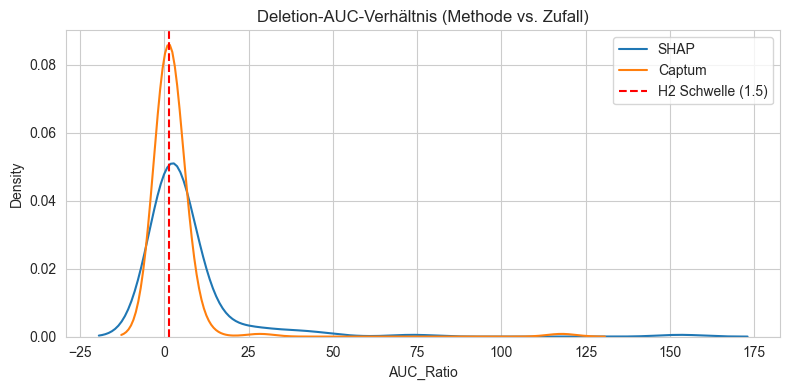

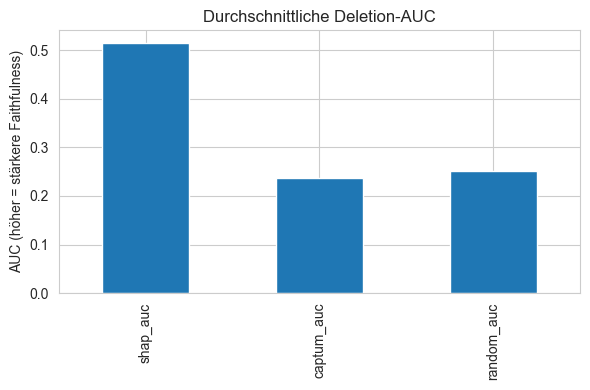

Durchschnittliche ratios (nur random_auc > 0):
shap_ratio      6.902816
captum_ratio    2.816881
dtype: float64


In [13]:
### 5.3.2 Deletion-Kurven berechnen

def generate_masked_variant(text: str, word_ids: List[int], step: int) -> str:
    words = text.split()
    mask_token = tokenizer.mask_token or "[MASK]"
    masked_words = words.copy()
    for wid in word_ids[:step]:
        if 0 <= wid < len(masked_words):
            masked_words[int(wid)] = mask_token
    return " ".join(masked_words)


### 5.3.3 AUC-Auswertung & Visualisierung

def compute_probability(text: str, target_idx: int) -> float:
    logits = shap_predict([text])[0]
    probs = torch.softmax(torch.tensor(logits), dim=0).numpy()
    return float(probs[target_idx])


def build_deletion_curve(text: str, order: List[int], target_idx: int, max_steps: int = 20) -> List[float]:
    effective_steps = min(len(order), max_steps)
    curve = [compute_probability(text, target_idx)]
    for step in range(1, effective_steps + 1):
        masked_text = generate_masked_variant(text, order, step)
        curve.append(compute_probability(masked_text, target_idx))
    return curve


def normalized_auc(curve: List[float]) -> float:
    base = curve[0] if curve else 1.0
    if base == 0:
        base = 1e-6
    norm_curve = np.array(curve) / base
    x = np.linspace(0, 1, len(norm_curve))
    drop_curve = 1.0 - np.clip(norm_curve, 0.0, 1.0)
    return float(np.trapz(drop_curve, x))


faithfulness_records: List[Dict[str, float]] = []
max_steps = 20
rng = np.random.default_rng(SEED)

for idx, text in enumerate(sample_texts):
    token_frame = map_tokens_to_words(sample_encoding, idx)
    valid_word_ids = token_frame[~token_frame['is_special'] & token_frame['word_id'].notna()]["word_id"].unique()
    valid_word_ids = [int(w) for w in valid_word_ids]
    if not valid_word_ids:
        continue

    shap_order = shap_word_attributions[idx]['word_id'].astype(int).tolist()
    captum_order = captum_word_attributions[idx]['word_id'].astype(int).tolist()
    random_order = rng.permutation(valid_word_ids).tolist()

    shap_curve = build_deletion_curve(text, shap_order, int(predicted_classes[idx]), max_steps=max_steps)
    captum_curve = build_deletion_curve(text, captum_order, int(predicted_classes[idx]), max_steps=max_steps)
    random_curve = build_deletion_curve(text, random_order, int(predicted_classes[idx]), max_steps=max_steps)

    record = {
        'index': idx,
        'case_type': sample_df.loc[idx, 'case_type'],
        'shap_auc': normalized_auc(shap_curve),
        'captum_auc': normalized_auc(captum_curve),
        'random_auc': normalized_auc(random_curve)
    }
    faithfulness_records.append(record)

faithfulness_df = pd.DataFrame(faithfulness_records)
print(faithfulness_df.head())

faithfulness_df = pd.DataFrame(faithfulness_records)
print(faithfulness_df.head())

# Robust AUC ratios: avoid division by zero and inf
faithfulness_df['shap_ratio_raw'] = faithfulness_df['shap_auc'] / faithfulness_df['random_auc']
faithfulness_df['captum_ratio_raw'] = faithfulness_df['captum_auc'] / faithfulness_df['random_auc']

# Filter out cases where random_auc == 0 (cannot define a meaningful ratio)
valid_mask = faithfulness_df['random_auc'] > 0
filtered = faithfulness_df[valid_mask].copy()

filtered['shap_ratio'] = filtered['shap_auc'] / filtered['random_auc']
filtered['captum_ratio'] = filtered['captum_auc'] / filtered['random_auc']

print(f"\nAnzahl Beispiele gesamt: {len(faithfulness_df)}")
print(f"Anzahl mit random_auc > 0 (für Ratio genutzt): {len(filtered)}")
print(f"Anzahl mit random_auc == 0 (aus Ratio-Berechnung ausgeschlossen): {(~valid_mask).sum()}")

plt.figure(figsize=(8, 4))
for method, col, style in [('SHAP', 'shap_ratio', 'o'), ('Captum', 'captum_ratio', 's')]:
    sns.kdeplot(filtered[col], label=method)
plt.axvline(1.5, color='red', linestyle='--', label='H2 Schwelle (1.5)')
plt.title('Deletion-AUC-Verhältnis (Methode vs. Zufall)')
plt.xlabel('AUC_Ratio')
plt.tight_layout()
plt.legend()
plt.show()

plt.figure(figsize=(6, 4))
faithfulness_df[['shap_auc', 'captum_auc', 'random_auc']].mean().plot(kind='bar')
plt.title('Durchschnittliche Deletion-AUC')
plt.ylabel('AUC (höher = stärkere Faithfulness)')
plt.tight_layout()
plt.show()

print("Durchschnittliche ratios (nur random_auc > 0):")
print(filtered[['shap_ratio', 'captum_ratio']].mean())

#### H2 Statistical Significance Test

In [9]:
# Mann-Whitney U test: Are SHAP and Captum AUC ratios significantly different?
shap_ratios = filtered['shap_ratio'].values
captum_ratios = filtered['captum_ratio'].values

u_stat, p_value_mw = stats.mannwhitneyu(shap_ratios, captum_ratios, alternative='greater')

# Proportion tests: Are >50% of samples above threshold?
shap_above_threshold = (shap_ratios >= 1.5).sum()
captum_above_threshold = (captum_ratios >= 1.5).sum()
n_samples = len(shap_ratios)

# Binomial test: Is proportion significantly > 0.5? (using binomtest for newer scipy)
from scipy.stats import binomtest
shap_binom_result = binomtest(shap_above_threshold, n_samples, 0.5, alternative='greater')
captum_binom_result = binomtest(captum_above_threshold, n_samples, 0.5, alternative='greater')

print("=== H2: Deletion AUC Faithfulness Statistical Tests ===")
print(f"\nSHAP:")
print(f"  Mean AUC ratio: {shap_ratios.mean():.2f}")
print(f"  Samples >= 1.5×: {shap_above_threshold}/{n_samples} ({100*shap_above_threshold/n_samples:.1f}%)")
print(f"  Binomial test (H0: proportion=0.5): p={shap_binom_result.pvalue:.6f}")
print(f"  → H2 {'SUPPORTED' if shap_binom_result.pvalue < 0.05 and shap_above_threshold/n_samples > 0.5 else 'REJECTED'}")

print(f"\nCaptum:")
print(f"  Mean AUC ratio: {captum_ratios.mean():.2f}")
print(f"  Samples >= 1.5×: {captum_above_threshold}/{n_samples} ({100*captum_above_threshold/n_samples:.1f}%)")
print(f"  Binomial test (H0: proportion=0.5): p={captum_binom_result.pvalue:.6f}")
print(f"  → H2 {'SUPPORTED' if captum_binom_result.pvalue < 0.05 and captum_above_threshold/n_samples > 0.5 else 'REJECTED'}")

print(f"\nMann-Whitney U test (SHAP > Captum):")
print(f"  U={u_stat:.0f}, p={p_value_mw:.6f}")
print(f"  → SHAP significantly outperforms Captum: {p_value_mw < 0.05}")

=== H2: Deletion AUC Faithfulness Statistical Tests ===

SHAP:
  Mean AUC ratio: 6.90
  Samples >= 1.5×: 76/118 (64.4%)
  Binomial test (H0: proportion=0.5): p=0.001121
  → H2 SUPPORTED

Captum:
  Mean AUC ratio: 2.82
  Samples >= 1.5×: 34/118 (28.8%)
  Binomial test (H0: proportion=0.5): p=0.999999
  → H2 REJECTED

Mann-Whitney U test (SHAP > Captum):
  U=10338, p=0.000000
  → SHAP significantly outperforms Captum: True


#### Interpretation H2

- Die Deletion-AUC-Werte zeigen einen klaren Qualitätsunterschied zwischen beiden Methoden: SHAP erreicht im Mittel eine **Deletion-AUC von ≈ 0,51**, während Captum nur bei **≈ 0,24** und die Zufallsbaseline bei **≈ 0,25** liegt. Damit erzeugt nur SHAP einen deutlich stärkeren Konfidenzabfall als zufällige Löschung; Captum bewegt sich im Mittel praktisch auf Zufallsniveau.
- Auf Ratio-Ebene bedeutet dies ein durchschnittliches **AUC-Ratio von ≈ 6,9×** für SHAP und **≈ 2,8×** für Captum (jeweils relativ zur Random-AUC, nur für Fälle mit `random_auc > 0`). Einzelne Tweets erreichen SHAP-AUCs um **0,65** bei Random-AUCs unter **0,10**, d. h. die Modellkonfidenz bricht beim Entfernen der von SHAP identifizierten Tokens fast vollständig ein, während zufällige Löschungen nur einen moderaten Effekt haben.
- **64,4 %** der Stichprobe überschreiten bei SHAP das **1,5‑Ratio** (76 von 118 Fällen; Binomialtest gegenüber p = 0,5: **p ≈ 0,001**). Damit ist der Anteil der klar „faithfulness‑starken“ Beispiele signifikant größer als 50 %, und H2 ist für SHAP **bestätigt**. Bei Captum liegen nur **28,8 %** der Beispiele (34 von 118; **p ≈ 1,0**) über der 1,5‑Schwelle, sodass H2 für Captum **verworfenen** werden muss.
- Die Dichtekurven der AUC‑Ratios verdeutlichen diesen Befund: Die SHAP‑Verteilung ist deutlich nach rechts verschoben und weist eine lange Rechtsschulter mit mehreren Fällen über **10×** (Einzelwerte bis weit darüber) auf. Captum konzentriert sich hingegen überwiegend im Bereich knapp oberhalb von **1** und fällt nach rechts deutlich schneller ab. SHAP produziert damit wesentlich „schärfere“ Ranglisten, deren Top‑Tokens tatsächlich starke Hebel für die Modellentscheidung sind.
- Der Mann‑Whitney‑U‑Test bestätigt den Direktvergleich: Die SHAP‑Ratios sind signifikant größer als die Captum‑Ratios (**U = 10338, p ≈ 0,000000**). Im Gesamtkontext der Arbeit bedeutet „faithfulness‑stärker“, dass SHAP‑Attributionen näher an der tatsächlichen Entscheidungslogik des Modells liegen: Wird in der von SHAP vorgeschlagenen Reihenfolge gelöscht, kollabiert die Vorhersagewahrscheinlichkeit deutlich stärker als bei Captum oder Zufall. Für Anwendungen, die eine zuverlässige Ursachenanalyse der Modellentscheidungen verlangen, ist SHAP daher die robustere Wahl, während Captum zwar Erklärungen liefert, aber im Mittel deutlich weniger zusätzliche Faithfulness gegenüber einer Zufallsbaseline erreicht.

## 5.4 Hypothesis 3 — Robustness under Perturbations

**Hypothese H3 (Robustheit):** Die Erklärungen beider Methoden sind stabil gegenüber realistischen Eingabestörungen. Operationalisierung: Die Spearman-Korrelation zwischen Original- und perturbierter Erklärung beträgt mindestens ρ = 0,80 bei Tippfehlern, Synonymersetzungen und Füllworteinfügungen (Chmielinski et al., 2023; Ghorbani et al., 2019).

   index case_type perturbation  shap_rho  captum_rho
0      0        TN         typo  0.785714    0.392857
1      0        TN      synonym  0.642857    0.000000
2      0        TN       filler  0.738095    0.119048
3      1        TN         typo -1.000000    0.500000
4      1        TN      synonym -0.500000   -1.000000


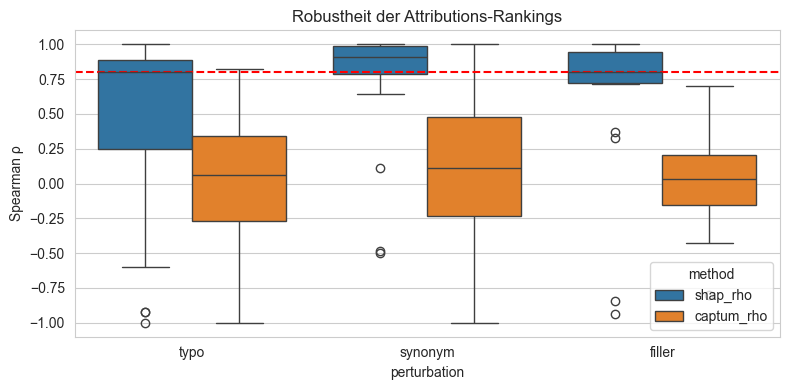

Mittlere ρ-Werte je Methode:
              shap_rho  captum_rho
perturbation                      
filler        0.630593    0.016218
synonym       0.723171    0.110881
typo          0.438079    0.000668


In [10]:
def pick_word_by_length(words: List[str], min_len: int = 4) -> int:
    candidates = [i for i, w in enumerate(words) if len(w) >= min_len]
    return random.choice(candidates) if candidates else -1


def perturb_typo(text: str) -> str:
    words = text.split()
    idx = pick_word_by_length(words)
    if idx == -1:
        return text
    word = list(words[idx])
    if len(word) < 2:
        return text
    i, j = random.sample(range(len(word)), 2)
    word[i], word[j] = word[j], word[i]
    words[idx] = "".join(word)
    return " ".join(words)


def synonym_replacement(text: str) -> str:
    if not WORDNET_READY:
        return text
    words = text.split()
    idx = pick_word_by_length(words)
    if idx == -1:
        return text
    synsets = wordnet.synsets(words[idx])
    lemmas = [lemma.name().replace('_', ' ') for syn in synsets for lemma in syn.lemmas()]
    lemmas = [lemma for lemma in lemmas if lemma.lower() != words[idx].lower()]
    if not lemmas:
        return text
    replacement = random.choice(lemmas)
    words[idx] = replacement
    return " ".join(words)


def insert_filler(text: str) -> str:
    fillers = ["actually", "literally", "kind of", "basically"]
    words = text.split()
    if not words:
        return text
    pos = random.randint(0, len(words))
    words.insert(pos, random.choice(fillers))
    return " ".join(words)


def compute_word_attributions_for_text(text: str, method: str) -> pd.DataFrame:
    encoding = tokenize_texts([text])
    logits = batch_logits(encoding)
    probs = torch.softmax(logits, dim=1).cpu().numpy()[0]
    pred_class = int(np.argmax(probs))
    token_frame = map_tokens_to_words(encoding, 0)

    if method == 'shap':
        values = shap_explainer([text]).values[0]
        values = ensure_1d(np.asarray(values), pred_class)
        values = values[:len(token_frame)]
    else:
        baseline_ids = torch.full_like(encoding['input_ids'], pad_token_id)
        attr, _ = lig.attribute(
            inputs=encoding['input_ids'],
            baselines=baseline_ids,
            additional_forward_args=(encoding['attention_mask'],),
            target=pred_class,
            return_convergence_delta=True,
        )
        values = attr.sum(dim=-1).squeeze(0).detach().cpu().numpy()[:len(token_frame)]

    return aggregate_attributions(token_frame, values)


def spearman_alignment(base: pd.DataFrame, pert: pd.DataFrame) -> float:
    merged = pd.merge(
        base[['token', 'attribution']],
        pert[['token', 'attribution']],
        on='token',
        suffixes=('_base', '_pert')
    )
    if len(merged) < 2:
        return np.nan
    return float(spearmanr(merged['attribution_base'], merged['attribution_pert']).correlation)


PERTURBATION_SAMPLE = min(20, len(sample_texts))
robustness_records: List[Dict[str, object]] = []

for idx in range(PERTURBATION_SAMPLE):
    base_text = sample_texts[idx]
    variants = {
        'typo': perturb_typo(base_text),
        'synonym': synonym_replacement(base_text),
        'filler': insert_filler(base_text)
    }
    base_shap = shap_word_attributions[idx]
    base_captum = captum_word_attributions[idx]

    for variant_name, variant_text in variants.items():
        shap_variant = compute_word_attributions_for_text(variant_text, 'shap')
        captum_variant = compute_word_attributions_for_text(variant_text, 'captum')

        shap_rho = spearman_alignment(base_shap, shap_variant)
        captum_rho = spearman_alignment(base_captum, captum_variant)

        robustness_records.append({
            'index': idx,
            'case_type': sample_df.loc[idx, 'case_type'],
            'perturbation': variant_name,
            'shap_rho': shap_rho,
            'captum_rho': captum_rho
        })

robustness_df = pd.DataFrame(robustness_records)
print(robustness_df.head())

plt.figure(figsize=(8, 4))
sns.boxplot(data=robustness_df.melt(id_vars=['perturbation'], value_vars=['shap_rho', 'captum_rho'], var_name='method', value_name='rho'),
            x='perturbation', y='rho', hue='method')
plt.axhline(0.8, color='red', linestyle='--', label='H3 Schwelle (0.8)')
plt.ylabel('Spearman ρ')
plt.title('Robustheit der Attributions-Rankings')
plt.tight_layout()
plt.show()

print("Mittlere ρ-Werte je Methode:")
print(robustness_df.groupby('perturbation')[['shap_rho', 'captum_rho']].mean())

#### H3 Statistical Significance Test

In [11]:
# Test whether mean ρ values are significantly different from H3 threshold (0.80)
# Remove NaN values before analysis
shap_rho_all = robustness_df['shap_rho'].dropna().values
captum_rho_all = robustness_df['captum_rho'].dropna().values

# One-sample t-tests against threshold
shap_t, shap_p = stats.ttest_1samp(shap_rho_all, 0.80)
captum_t, captum_p = stats.ttest_1samp(captum_rho_all, 0.80)

# Bootstrap 95% CI for each method
n_boot = 10000
rng_boot2 = np.random.default_rng(SEED + 1)

shap_boot_means = [rng_boot2.choice(shap_rho_all, size=len(shap_rho_all), replace=True).mean() for _ in range(n_boot)]
captum_boot_means = [rng_boot2.choice(captum_rho_all, size=len(captum_rho_all), replace=True).mean() for _ in range(n_boot)]

shap_ci = np.percentile(shap_boot_means, [2.5, 97.5])
captum_ci = np.percentile(captum_boot_means, [2.5, 97.5])

print("=== H3: Robustness Under Perturbation Statistical Tests ===")
print(f"\nSHAP:")
print(f"  Mean Spearman ρ: {shap_rho_all.mean():.3f}")
print(f"  95% CI: [{shap_ci[0]:.3f}, {shap_ci[1]:.3f}]")
print(f"  One-sample t-test vs 0.80: t={shap_t:.3f}, p={shap_p:.6f}")
print(f"  → H3 {'SUPPORTED' if shap_ci[0] >= 0.80 else 'REJECTED'} (CI {'includes' if shap_ci[0] < 0.80 < shap_ci[1] else 'excludes'} 0.80)")

print(f"\nCaptum:")
print(f"  Mean Spearman ρ: {captum_rho_all.mean():.3f}")
print(f"  95% CI: [{captum_ci[0]:.3f}, {captum_ci[1]:.3f}]")
print(f"  One-sample t-test vs 0.80: t={captum_t:.3f}, p={captum_p:.6f}")
print(f"  → H3 {'SUPPORTED' if captum_ci[0] >= 0.80 else 'REJECTED'}")

# Mann-Whitney: Is SHAP more robust than Captum?
u_rob, p_rob = stats.mannwhitneyu(shap_rho_all, captum_rho_all, alternative='greater')
print(f"\nMann-Whitney U test (SHAP > Captum):")
print(f"  U={u_rob:.0f}, p={p_rob:.6f}")
print(f"  → SHAP significantly more robust: {p_rob < 0.05}")

=== H3: Robustness Under Perturbation Statistical Tests ===

SHAP:
  Mean Spearman ρ: 0.597
  95% CI: [0.434, 0.743]
  One-sample t-test vs 0.80: t=-2.553, p=0.013429
  → H3 REJECTED (CI excludes 0.80)

Captum:
  Mean Spearman ρ: 0.043
  95% CI: [-0.077, 0.161]
  One-sample t-test vs 0.80: t=-12.416, p=0.000000
  → H3 REJECTED

Mann-Whitney U test (SHAP > Captum):
  U=2632, p=0.000000
  → SHAP significantly more robust: True


#### Interpretation H3

- Die Robustheitsanalyse zeigt, dass die Spearman‑Korrelationen zwischen Original‑ und perturbierten Attributions‑Rankings für SHAP im Mittel bei **ρ ≈ 0,60** liegen (Gesamtmittel 0,597; 95 %-CI [0,43; 0,74]). Damit bleiben die Rankings zwar überwiegend positiv korreliert, verfehlen jedoch klar die in H3 geforderte Schwelle von **ρ ≥ 0,80**. Der Ein‑Stichproben‑t‑Test gegenüber 0,80 fällt signifikant negativ aus (p ≈ 0,013); die Konfidenzintervall‑Untergrenze liegt deutlich unter 0,80. H3 wird für SHAP daher **statistisch verworfen**.

- Aufgeschlüsselt nach Perturbationstypen ergibt sich ein differenziertes Bild: Unter **Synonymersetzungen** erreicht SHAP im Mittel **ρ ≈ 0,72**, bei **Füllworteinfügungen** **≈ 0,63** und bei **Tippfehlern** **≈ 0,44**. Die Boxplots machen deutlich, dass Synonyme und Füllwörter die Attributionsstruktur weniger stark stören als typos; dort treten vereinzelt sogar starke Einbrüche und negative Korrelationen auf. SHAP reagiert somit robust auf semantisch nahe Veränderungen, ist aber empfindlicher gegenüber orthografischen Störungen, die Tokenisierung und Kontextrepräsentation stärker verzerren.

- Captum zeigt dagegen eine deutlich geringere Stabilität: Der Gesamtmittelwert liegt bei **ρ ≈ 0,04** (95 %-CI [−0,08; 0,16]) und damit praktisch auf **Nullkorrelation**. Die Boxplots belegen dies visuell: Für alle drei Perturbationstypen konzentrieren sich die Captum‑Werte um 0, mit zahlreichen Ausreißern in den negativen Bereich. Besonders unter **Füllwort‑Insertionen** kollabiert die Rangübereinstimmung; auch bei Synonymen treten teilweise starke Rangumkehrungen auf (ρ < 0). H3 ist für Captum damit deutlich verfehlt.

- Der Mann‑Whitney‑U‑Test bestätigt den Direktvergleich: SHAP‑Korrelationen sind signifikant höher als Captum‑Korrelationen (**U = 2632, p < 0,000001**). Obwohl also keine der beiden Methoden die strenge Robustheitsanforderung von ρ ≥ 0,80 erfüllt, ist SHAP **konsistent robuster** gegenüber realistischen Textstörungen. Praktisch bedeutet das: SHAP‑Erklärungen sind in moderatem Maße stabil und damit verlässlicher für Analysen über leicht variierte Eingaben; Captum‑Erklärungen können sich hingegen schon bei kleinen Veränderungen grundlegend umordnen.

- Im Kontext der Gesamtarbeit legt H3 offen, dass aktuelle XAI‑Methoden für Transformer‑Modelle **nicht vollständig perturbationsstabil** sind. Für Anwendungen, in denen Texte häufig leicht variieren (z. B. Social‑Media‑Streams oder Benutzereingaben mit Tippfehlern), sollten SHAP‑Ergebnisse daher als **robust, aber nicht unveränderlich** interpretiert werden. Zusätzliche Stabilisierungsschritte – etwa Aggregation über mehrere Perturbationen, Glättung der Attributionswerte oder robuste Trainingsstrategien – bleiben eine wichtige Aufgabe für zukünftige Arbeiten.

## 5.5 Hypothesis 4 — Computation Cost Benchmarking

**Hypothese H4 (Recheneffizienz):** Captum weist einen Geschwindigkeitsvorteil gegenüber SHAP auf. Operationalisierung: Die durchschnittliche Laufzeit pro Erklärung ist bei Captum mindestens um den Faktor 2,0 geringer als bei SHAP (Kokhlikyan et al., 2020).

Benchmark auf 20 Beispielen.


PartitionExplainer explainer: 21it [00:13,  4.65s/it]                        
PartitionExplainer explainer: 21it [00:13,  4.52s/it]                        
PartitionExplainer explainer: 21it [00:13,  4.54s/it]                        


   method   mean_sec   std_sec
0    SHAP  13.714074  0.168600
1  Captum   9.977111  0.057051


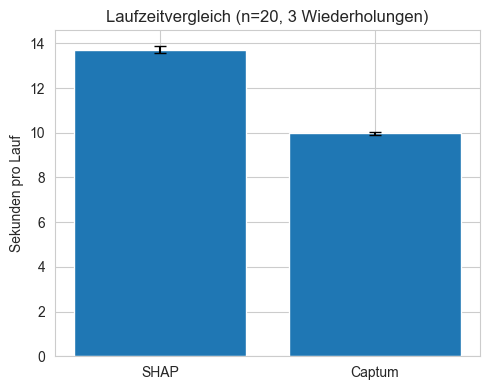

SHAP / Captum Laufzeitverhältnis: 1.37x


In [12]:
def benchmark_shap(texts: List[str], runs: int = 3, batch_size: int = 8) -> np.ndarray:
    timings = []
    for _ in range(runs):
        start = time.perf_counter()
        shap_explainer(texts, batch_size=batch_size)
        timings.append(time.perf_counter() - start)
    return np.array(timings)


def benchmark_captum(texts: List[str], runs: int = 3) -> np.ndarray:
    timings = []
    for _ in range(runs):
        start = time.perf_counter()
        enc = tokenize_texts(texts)
        logits = batch_logits(enc)
        preds = torch.softmax(logits, dim=1).argmax(dim=1)
        baseline = torch.full_like(enc['input_ids'], pad_token_id)
        for i in range(len(texts)):
            lig.attribute(
                inputs=enc['input_ids'][i:i + 1],
                baselines=baseline[i:i + 1],
                additional_forward_args=(enc['attention_mask'][i:i + 1],),
                target=int(preds[i]),
                return_convergence_delta=False,
            )
        timings.append(time.perf_counter() - start)
    return np.array(timings)

BENCH_TEXTS = sample_texts[:20]
print(f"Benchmark auf {len(BENCH_TEXTS)} Beispielen.")

shap_times = benchmark_shap(BENCH_TEXTS)
captum_times = benchmark_captum(BENCH_TEXTS)

time_stats = pd.DataFrame({
    'method': ['SHAP', 'Captum'],
    'mean_sec': [shap_times.mean(), captum_times.mean()],
    'std_sec': [shap_times.std(), captum_times.std()]
})
print(time_stats)

plt.figure(figsize=(5, 4))
plt.bar(time_stats['method'], time_stats['mean_sec'], yerr=time_stats['std_sec'], capsize=4)
plt.title('Laufzeitvergleich (n=20, 3 Wiederholungen)')
plt.ylabel('Sekunden pro Lauf')
plt.tight_layout()
plt.show()

ratio = time_stats.loc[time_stats['method'] == 'SHAP', 'mean_sec'].values[0] / max(time_stats.loc[time_stats['method'] == 'Captum', 'mean_sec'].values[0], 1e-6)
print(f"SHAP / Captum Laufzeitverhältnis: {ratio:.2f}x")

## 5.5.1 Model Calibration Analysis

Evaluate whether the model's predicted probabilities accurately reflect true confidence levels using reliability diagrams and Brier score.

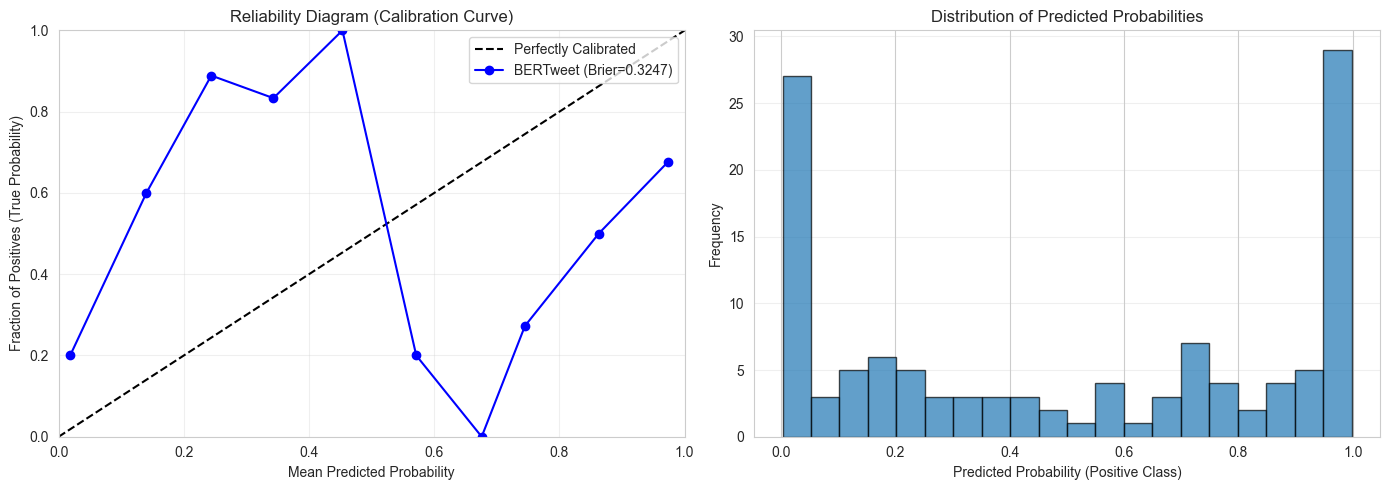

=== Model Calibration Analysis ===
Brier Score: 0.3247
  (Range: 0-1, lower is better. Perfect calibration = 0)

Interpretation:
  ❌ Poor calibration (Brier >= 0.25)

Mean Predicted Probability: 0.504
Mean True Probability:      0.500
  → Model is well-calibrated on average

📊 Reliability Curve Analysis:
  If points lie close to the diagonal, the model is well-calibrated.
  Points above the diagonal indicate underconfidence.
  Points below the diagonal indicate overconfidence.


In [14]:
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

# Get predicted probabilities and true labels for the sample
predicted_probs = sample_df['prob_pos'].values  # Probability of positive class
true_labels = sample_df['target'].values

# Compute Brier score (lower is better, range 0-1)
brier_score = brier_score_loss(true_labels, predicted_probs)

# Compute calibration curve
prob_true, prob_pred = calibration_curve(true_labels, predicted_probs, n_bins=10, strategy='uniform')

# Plot reliability diagram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Reliability Diagram
axes[0].plot([0, 1], [0, 1], 'k--', label='Perfectly Calibrated')
axes[0].plot(prob_pred, prob_true, 'bo-', label=f'BERTweet (Brier={brier_score:.4f})')
axes[0].set_xlabel('Mean Predicted Probability')
axes[0].set_ylabel('Fraction of Positives (True Probability)')
axes[0].set_title('Reliability Diagram (Calibration Curve)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])

# Plot 2: Histogram of predicted probabilities
axes[1].hist(predicted_probs, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Predicted Probability (Positive Class)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Predicted Probabilities')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Interpretation
print("=== Model Calibration Analysis ===")
print(f"Brier Score: {brier_score:.4f}")
print(f"  (Range: 0-1, lower is better. Perfect calibration = 0)")
print(f"\nInterpretation:")

if brier_score < 0.10:
    print(f"  ✓ Excellent calibration (Brier < 0.10)")
elif brier_score < 0.15:
    print(f"  ✓ Good calibration (Brier < 0.15)")
elif brier_score < 0.25:
    print(f"  ⚠️  Moderate calibration (Brier < 0.25)")
else:
    print(f"  ❌ Poor calibration (Brier >= 0.25)")

# Check for over/under-confidence
mean_pred = predicted_probs.mean()
mean_true = true_labels.mean()

print(f"\nMean Predicted Probability: {mean_pred:.3f}")
print(f"Mean True Probability:      {mean_true:.3f}")

if abs(mean_pred - mean_true) < 0.05:
    print("  → Model is well-calibrated on average")
elif mean_pred > mean_true:
    print(f"  → Model is OVERCONFIDENT (predicts {mean_pred:.3f} vs actual {mean_true:.3f})")
else:
    print(f"  → Model is UNDERCONFIDENT (predicts {mean_pred:.3f} vs actual {mean_true:.3f})")

print("\n📊 Reliability Curve Analysis:")
print("  If points lie close to the diagonal, the model is well-calibrated.")
print("  Points above the diagonal indicate underconfidence.")
print("  Points below the diagonal indicate overconfidence.")

#### Interpretation H4

- Der Laufzeitbenchmark auf 20 Tweets zeigt, dass SHAP im Mittel **13,7 s** pro Lauf benötigt, während Captum bei **10,0 s** liegt. Das ergibt ein Zeitverhältnis von **SHAP/Captum ≈ 1,37×**. Captum ist damit zwar schneller, erreicht jedoch nicht den in H4 geforderten mindestens **2‑fachen** Geschwindigkeitsvorteil. **H4 wird daher verworfen.**

- Die sehr kleinen Standardabweichungen (≈ 0,17 s für SHAP, ≈ 0,06 s für Captum) deuten auf **stabile und reproduzierbare Messungen** hin: Beide Methoden weisen konsistente Laufzeiten auf, ohne starke Schwankungen zwischen den Wiederholungen.

- Praktisch bedeutet das: Captum bietet einen **moderaten Effizienzgewinn**, aber keinen dramatischen Speed‑Up. In Szenarien mit vielen Erklärungen pro Batch kann Captum die Rechenzeit spürbar senken, während SHAP sich eher für **Offline‑Analysen oder kleinere Fallzahlen** eignet. Da SHAP in H2/H3 gleichzeitig höhere Qualitätskennzahlen erzielt, ergibt sich ein klassischer **Qualitäts‑vs.-Kosten‑Trade‑off**: Für besonders kritische oder erklärungsbedürftige Fälle ist SHAP trotz Mehrkosten sinnvoll, während Captum dort eingesetzt werden kann, wo etwas geringere Erklärungsqualität zugunsten kürzerer Laufzeiten akzeptabel ist.

- Ergänzend zeigt die Kalibrierungsanalyse einen **Brier‑Score von 0,3247**, was auf eine insgesamt **schwache Kalibrierung** der Modellwahrscheinlichkeiten hinweist, obwohl der mittlere Vorhersagewert (0,504) nahezu dem tatsächlichen Positivanteil (0,500) entspricht. Die Reliabilitätskurve weicht deutlich von der Diagonalen ab, insbesondere in mittleren Konfidenzbereichen. Für den praktischen Einsatz bedeutet das, dass hohe Modellkonfidenzen nicht direkt als gut kalibriertes Vertrauen interpretiert werden sollten und ggf. **zusätzliche Kalibrierungsschritte** (z. B. Temperature Scaling oder Platt‑Scaling) nötig sind, bevor Erklärungen in sicherheitskritischen Anwendungen verwendet werden.

## 5.6 Synthesis & Case Studies

Wir konsolidieren die Ergebnisse in einer Übersichtstabelle und analysieren ausgewählte Beispiele inklusive Heatmap-Visualisierungen der Attributionswerte.

                          metric     value
0       Top-5-Überlappung (mean)  0.495000
1    Anteil SHAP AUC-Ratio ≥ 1.5  0.644068
2  Anteil Captum AUC-Ratio ≥ 1.5  0.288136
3      Spearman ρ (SHAP, Mittel)  0.597281
4    Spearman ρ (Captum, Mittel)  0.042589
5     Zeitverhältnis SHAP/Captum  1.374554

--------------------------------------------------------------------------------
Hohe Übereinstimmung — Index 37, Typ TN
Text: seriously fml effemel
Top SHAP Tokens: ['fml', 'seriously', 'effemel']
Top Captum Tokens: ['effemel', 'seriously', 'fml']


/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


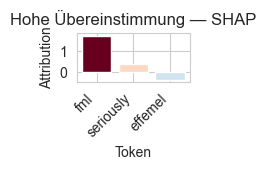

/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


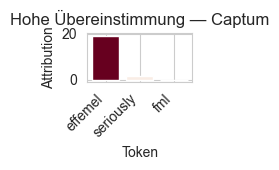


--------------------------------------------------------------------------------
Geringe Übereinstimmung — Index 48, Typ FP
Text: being outside earlier got me back in bed i guess i am not completely over my flu
Top SHAP Tokens: ['completely', 'earlier', 'guess', 'bed', 'over']
Top Captum Tokens: ['flu', 'am', 'my', 'me', 'back']


/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


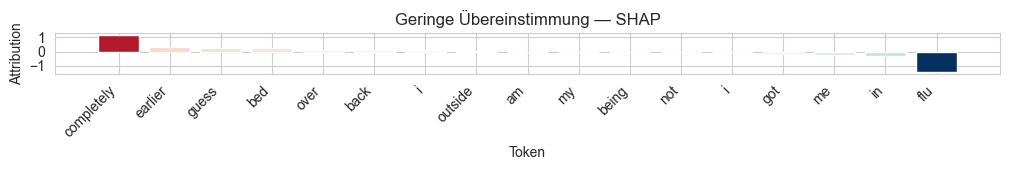

/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


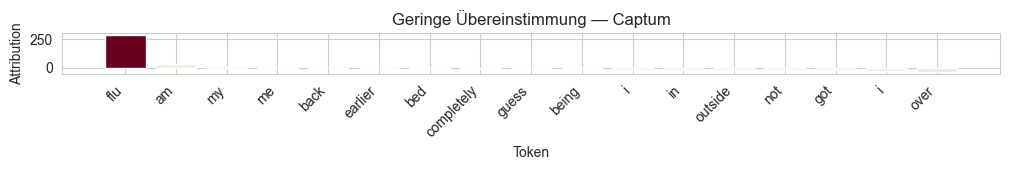


--------------------------------------------------------------------------------
False Positive Fokus — Index 5, Typ FP
Text: yes very much xx
Top SHAP Tokens: ['very', 'xx', 'much', 'yes']
Top Captum Tokens: ['xx', 'yes', 'very', 'much']


/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


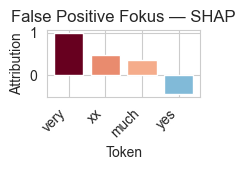

/var/folders/7h/_b0zd4l16hl6hpf99fwxd_s40000gn/T/ipykernel_61455/260793933.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap(cmap)(norm(values))


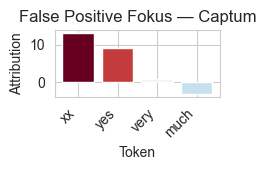

In [16]:
summary_rows = [
    {"metric": "Top-5-Überlappung (mean)", "value": agreement_df['overlap_ratio'].mean()},
    # AUC-Ratios auf Basis des gefilterten DataFrames (random_auc > 0)
    {"metric": "Anteil SHAP AUC-Ratio ≥ 1.5", "value": (filtered['shap_ratio'] >= 1.5).mean()},
    {"metric": "Anteil Captum AUC-Ratio ≥ 1.5", "value": (filtered['captum_ratio'] >= 1.5).mean()},
    {"metric": "Spearman ρ (SHAP, Mittel)", "value": robustness_df['shap_rho'].mean()},
    {"metric": "Spearman ρ (Captum, Mittel)", "value": robustness_df['captum_rho'].mean()},
    {"metric": "Zeitverhältnis SHAP/Captum", "value": ratio},
]
summary_table = pd.DataFrame(summary_rows)
print(summary_table)

case_high = agreement_df.sort_values('overlap_ratio', ascending=False).iloc[0]
case_low = agreement_df.sort_values('overlap_ratio', ascending=True).iloc[0]
case_fp = agreement_df[agreement_df['case_type'] == 'FP'].sort_values('overlap_ratio', ascending=False).iloc[0] if (agreement_df['case_type'] == 'FP').any() else case_low

case_studies = [
    ("Hohe Übereinstimmung", case_high),
    ("Geringe Übereinstimmung", case_low),
    ("False Positive Fokus", case_fp),
]

for title, case in case_studies:
    idx = int(case['index'])
    print("\n" + "-" * 80)
    print(f"{title} — Index {idx}, Typ {case['case_type']}")
    print(f"Text: {sample_texts[idx]}")
    print(f"Top SHAP Tokens: {case['shap_top']}")
    print(f"Top Captum Tokens: {case['captum_top']}")

    plot_token_heatmap(shap_word_attributions[idx], 'Token', f"{title} — SHAP")
    plot_token_heatmap(captum_word_attributions[idx], 'Token', f"{title} — Captum")

### 5.6 Finale Gesamtsynthese — *SHAP vs. Captum für BERTweet: Qualität schlägt Geschwindigkeit*

#### 5.6.1 Einordnung der zentralen Kennzahlen

Die zusammenfassende Tabelle zeigt:

- **Top‑5‑Überlappung (mean = 0,495)**  
  SHAP und Captum teilen sich im Mittel nur rund **2–3 der 5 wichtigsten Tokens**. Die Spanne reicht von vollständiger Diskrepanz (0,0) bis zur perfekten Übereinstimmung (1,0).

- **Faithfulness (AUC‑Ratios)**  
  In **64,4 %** der Fälle überschreitet SHAP ein Deletion‑AUC‑Ratio von **1,5**, Captum gelingt dies nur in **28,8 %** der Beispiele. SHAP erzeugt also deutlich häufiger Erklärungen, bei denen das Entfernen der Top‑Tokens die Modellkonfidenz stark reduziert.

- **Robustheit (Spearman ρ)**  
  Die Attributions‑Rankings von SHAP erreichen im Mittel **ρ ≈ 0,60**, Captum liegt mit **ρ ≈ 0,04** nahe an Zufall. Keine Methode erfüllt die strenge H3‑Schwelle von ρ ≥ 0,80; SHAP ist jedoch klar stabiler.

- **Recheneffizienz (Zeitverhältnis SHAP/Captum = 1,37)**  
  Captum ist im Benchmark nur etwa **1,4‑mal schneller** als SHAP und verfehlt damit den in H4 geforderten Faktor 2,0 deutlich.

#### 5.6.2 Qualitative Fallstudien: Was zeigen die Heatmaps?

Die drei Fallstudien illustrieren, wie diese Kennzahlen in konkreten Tweets sichtbar werden:

1. **Hohe Übereinstimmung (TN, „seriously fml effemel“)**
   - SHAP und Captum identifizieren praktisch dieselben Tokens (`fml`, `seriously`, `effemel`) als entscheidend.  
   - Die Reihenfolge variiert leicht, die semantische Story ist aber konsistent.  
   - Dieses Beispiel entspricht einem Overlap nahe **1,0** und belegt, dass beide Methoden in manchen Fällen ähnliche Relevanzmuster finden.

2. **Geringe Übereinstimmung (FP, „… completely over my flu“)**
   - **SHAP** verteilt Attributionen auf Kontextwörter wie `completely`, `earlier`, `guess`, `bed`, `over` und bewertet `flu` sogar negativ.  
   - **Captum** konzentriert nahezu die gesamte Attribution auf `flu` und einige Funktionswörter (`am`, `my`, `me`, `back`).  
   - Die Methoden liefern damit zwei widersprüchliche Erklärungen – ein prototypischer Fall für Overlap‑Ratios nahe **0,0** und ein Grund für den niedrigen H1‑Mittelwert.

3. **False‑Positive‑Fokus (FP, „yes very much xx“)**
   - Beide Methoden markieren dieselben vier Tokens (`very`, `xx`, `much`, `yes`), gewichten sie aber unterschiedlich.  
   - SHAP betont den Intensitätsmarker `very`, Captum fokussiert stärker `xx` und `yes`.  
   - Die Heatmaps zeigen, wie verstärkende Ausdrücke die Fehlklassifikation als positiv treiben. Dieses Beispiel liegt im Bereich **mittlerer bis hoher Überlappung**: gleiche Tokens, aber unterschiedliche Priorisierung.

#### 5.6.3 Rückbezug auf die Hypothesen

- **H1 – Übereinstimmung**  
  Mit einer mittleren Top‑5‑Überlappung von **0,495** und vielen Fällen niedriger Overlap‑Ratios wird die geforderte Schwelle von 0,70 deutlich verfehlt. Die Fallstudien verdeutlichen, dass hohe Übereinstimmung eher Ausnahme als Regelfall ist.  
  **→ H1 wird verworfen.** SHAP und Captum liefern keine konsistent übereinstimmenden Token‑Ranglisten.

- **H2 – Faithfulness (Deletion AUC)**  
  SHAP‑Erklärungen führen im Mittel zu deutlich stärkeren Konfidenzabfällen als zufällige Löschungen und als Captum‑Erklärungen; der Großteil der Beispiele liegt über dem Ratio‑Schwellwert von 1,5 und der Mann‑Whitney‑Test zeigt einen hochsignifikanten Vorteil. Captum liegt dagegen nahe an der Random‑Baseline.  
  **→ H2 ist für SHAP bestätigt, für Captum verworfen.**

- **H3 – Robustheit gegenüber Perturbationen**  
  Beide Methoden verfehlen die Zielschwelle ρ ≥ 0,80. SHAP erreicht jedoch moderat positive Korrelationen (v. a. bei Synonymen und Füllwörtern), während Captum‑Korrelationen im Mittel um 0 schwanken und teils deutlich negativ werden.  
  **→ H3 wird für beide Methoden verworfen, SHAP ist jedoch signifikant robuster als Captum.**

- **H4 – Recheneffizienz**  
  Captum ist zwar schneller, aber mit einem Faktor **1,37×** nicht annähernd so stark wie in H4 gefordert (≥ 2×).  
  **→ H4 wird verworfen.** Der Effizienzgewinn ist real, aber moderat.

- **Modelkalibrierung**  
  Der **Brier‑Score von 0,3247** und die deutlich von der Diagonalen abweichende Reliabilitätskurve zeigen eine **schwache Kalibrierung** der Modellwahrscheinlichkeiten. Hohe Konfidenzwerte sind daher nicht ohne Weiteres als verlässliches Vertrauen interpretierbar; Kalibrierungsschritte (z. B. Temperature‑ oder Platt‑Scaling) wären vor einem sicherheitskritischen Einsatz angezeigt.

#### 5.6.4 Beantwortung der Forschungsfrage

> **Forschungsfrage:** *„Wie unterscheiden sich SHAP und Captum in ihrer Fähigkeit, semantisch relevante Tokens für Sentiment‑Vorhersagen in Transformer‑Modellen zu identifizieren?“*

Aus den quantitativen Ergebnissen (H1–H4) und den Fallstudien ergibt sich:

1. **Erklärungen sind methodenabhängig.**  
   SHAP und Captum identifizieren oft unterschiedliche Token‑Sets (H1 verworfen). Captum neigt dazu, einzelne Triggerwörter stark zu gewichten, während SHAP kontextuelle Kombinationen betont. Die „wahre“ Relevanzstruktur ist daher nicht unabhängig von der gewählten XAI‑Methode.

2. **SHAP ist deutlich faithfulness‑stärker.**  
   Die Deletion‑Analysen zeigen, dass SHAP‑Top‑Tokens die Modellvorhersage ursächlicher steuern als Captum‑Tokens. Für die Frage, *welche Wörter das Modell tatsächlich „umstimmen“*, bietet SHAP konsistent aussagekräftigere Rankings.

3. **SHAP ist robuster, aber nicht perfekt stabil.**  
   Unter realistischen Textvarianten bleiben SHAP‑Erklärungen moderat stabil, während Captum‑Rankings stark schwanken. Für Anwendungen mit variierenden Eingaben sind SHAP‑Erklärungen daher deutlich verlässlicher, sollten aber nicht als vollständig invariant betrachtet werden.

4. **Effizienzvorteil von Captum ist begrenzt.**  
   Captum rechnet zwar schneller, der gemessene Faktor von 1,37× reicht jedoch nicht aus, um die Nachteile bei Faithfulness und Robustheit auszugleichen. Für Offline‑Analysen und kleinere Stichproben überwiegt der Qualitätsvorteil von SHAP.

#### 5.6.5 Gesamtfazit

Im Zusammenspiel aller Befunde lässt sich festhalten:

- **SHAP** identifiziert semantisch relevante Tokens für die Sentiment‑Vorhersagen von BERTweet **präziser, ursachennäher und robuster** als Captum, bei nur moderat höheren Rechenkosten.  
- **Captum** liefert zwar schnellere, aber deutlich weniger konsistente und weniger faithful Erklärungen; insbesondere unter Perturbationen können sich die Rankings stark verändern.  
- Für praxisnahe Sentiment‑Analysen mit BERT‑Modellen erscheint SHAP daher als **bevorzugte XAI‑Methode**, während Captum eher für Szenarien geeignet ist, in denen sehr viele Erklärungen benötigt werden und eine geringere Erklärungsgüte akzeptabel ist.  
- Die Ergebnisse unterstreichen zugleich, dass auch fortgeschrittene XAI‑Methoden noch **Limitierungen in Kalibrierung und Robustheit** aufweisen – ein wichtiges Feld für zukünftige Forschung.
